In [1]:
#!pip install gdown
!gdown 19boPIrMjS3AYlEvFMp8F02bmVegnrDnf # Source: kaggle.com
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import xgboost as xgb
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV 

Downloading...
From: https://drive.google.com/uc?id=19boPIrMjS3AYlEvFMp8F02bmVegnrDnf
To: /content/coin_Dogecoin.csv
100% 395k/395k [00:00<00:00, 87.1MB/s]


In [2]:
train = pd.read_csv('coin_Dogecoin.csv')
train.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Dogecoin,DOGE,2013-12-16 23:59:59,0.000866,0.000150,0.000299,0.000205,0.0,1.509085e+06
1,2,Dogecoin,DOGE,2013-12-17 23:59:59,0.000289,0.000116,0.000207,0.000269,0.0,2.169688e+06
2,3,Dogecoin,DOGE,2013-12-18 23:59:59,0.000362,0.000205,0.000267,0.000362,0.0,3.188943e+06
3,4,Dogecoin,DOGE,2013-12-19 23:59:59,0.001520,0.000328,0.000395,0.001162,0.0,1.115034e+07
4,5,Dogecoin,DOGE,2013-12-20 23:59:59,0.001143,0.000662,0.001143,0.000704,0.0,7.284337e+06


**Quick EDA to get some insights from the data.**

In [3]:
print(train.info())
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2760 non-null   int64  
 1   Name       2760 non-null   object 
 2   Symbol     2760 non-null   object 
 3   Date       2760 non-null   object 
 4   High       2760 non-null   float64
 5   Low        2760 non-null   float64
 6   Open       2760 non-null   float64
 7   Close      2760 non-null   float64
 8   Volume     2760 non-null   float64
 9   Marketcap  2760 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 215.8+ KB
None


,SNo,High,Low,Open,Close,Volume,Marketcap
count,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2.760000e+03,2.760000e+03
mean,1380.500000,0.014964,0.012402,0.013669,0.013763,4.326321e+08,1.760533e+09
std,796.887696,0.069103,0.055536,0.062347,0.062559,2.807320e+09,8.115186e+09
min,1.000000,0.000089,0.000085,0.000087,0.000087,0.000000e+00,1.509085e+06
25%,690.750000,0.000231,0.000222,0.000227,0.000226,2.536138e+05,2.337892e+07
50%,1380.500000,0.001914,0.001772,0.001849,0.001844,5.582480e+06,2.135789e+08
75%,2070.250000,0.002986,0.002796,0.002900,0.002899,5.098244e+07,3.488812e+08
max,2760.000000,0.737567,0.608168,0.687801,0.684777,6.941068e+10,8.868082e+10


In [4]:
train.index = pd.to_datetime(train['Date'])
train.drop(['Date','Name','Symbol','Volume','Marketcap','SNo'],axis=1,inplace=True) # had to drop some useful features to match the test data, could've kept the Volume but that would be very time consuming and its latee atm
train.index

DatetimeIndex(['2013-12-16 23:59:59', '2013-12-17 23:59:59',
               '2013-12-18 23:59:59', '2013-12-19 23:59:59',
               '2013-12-20 23:59:59', '2013-12-21 23:59:59',
               '2013-12-22 23:59:59', '2013-12-23 23:59:59',
               '2013-12-24 23:59:59', '2013-12-25 23:59:59',
               ...
               '2021-06-27 23:59:59', '2021-06-28 23:59:59',
               '2021-06-29 23:59:59', '2021-06-30 23:59:59',
               '2021-07-01 23:59:59', '2021-07-02 23:59:59',
               '2021-07-03 23:59:59', '2021-07-04 23:59:59',
               '2021-07-05 23:59:59', '2021-07-06 23:59:59'],
              dtype='datetime64[ns]', name='Date', length=2760, freq=None)

In [5]:
def create_features(df):
  df['dayofweek'] = df.index.day_of_week
  df['month'] = df.index.month
  df['dayofyear'] = df.index.dayofyear
  return df
train = create_features(train)
train.head()

,High,Low,Open,Close,dayofweek,month,dayofyear
Date,,,,,,,
2013-12-16 23:59:59,0.000866,0.000150,0.000299,0.000205,0,12,350
2013-12-17 23:59:59,0.000289,0.000116,0.000207,0.000269,1,12,351
2013-12-18 23:59:59,0.000362,0.000205,0.000267,0.000362,2,12,352
2013-12-19 23:59:59,0.001520,0.000328,0.000395,0.001162,3,12,353
2013-12-20 23:59:59,0.001143,0.000662,0.001143,0.000704,4,12,354


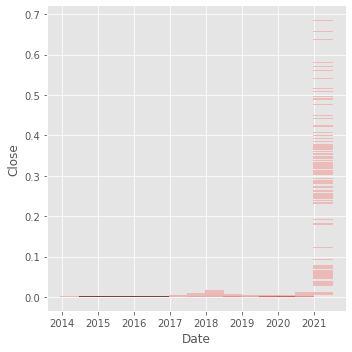

In [6]:
sns.displot(data=train,x=train.index ,y='Close')

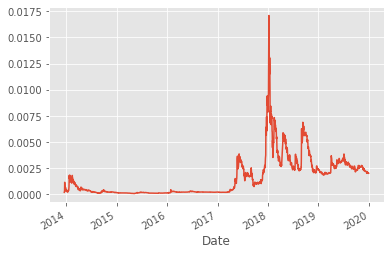

In [7]:
train['Close'].loc[(train.index < '01-01-2020')].plot() # Since there's a huge increase in value in 2021 we'll plot the Close price before that period of time.

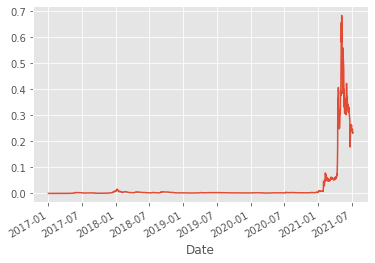

In [8]:
train['Close'].loc[train.index > '01-01-2017'].plot()

In [9]:
!gdown 1WNyI1DedTIhg6iaOYTA6qMTSQCBOCPJB # another dataset which i'll be using as test data. source: investing.com
newdf = pd.read_csv('dogecoin.csv')
test = newdf.iloc[::-1].reset_index(drop=True)
test.index = pd.to_datetime(test['Date'])
test.rename({'Price':'Close'},axis=1,inplace=True)
test.drop(['Date','Vol.','Change %'],axis=1,inplace=True)
test = test[['High','Low','Open','Close']]
test = create_features(test)
extended_df = train.append(test) # merging both train and test data and storing it in extended_df variable.
test

Downloading...
From: https://drive.google.com/uc?id=1WNyI1DedTIhg6iaOYTA6qMTSQCBOCPJB
To: /content/dogecoin.csv
100% 43.6k/43.6k [00:00<00:00, 37.2MB/s]


,High,Low,Open,Close,dayofweek,month,dayofyear
Date,,,,,,,
2021-07-07,0.236157,0.219121,0.233139,0.222236,2,7,188
2021-07-08,0.222825,0.204676,0.222249,0.207422,3,7,189
2021-07-09,0.228825,0.195927,0.207422,0.219272,4,7,190
2021-07-10,0.227071,0.209778,0.219219,0.213355,5,7,191
2021-07-11,0.218014,0.210114,0.213362,0.214666,6,7,192
...,...,...,...,...,...,...,...
2023-01-18,0.089473,0.079614,0.082806,0.080059,2,1,18
2023-01-19,0.082122,0.079946,0.080042,0.081613,3,1,19
2023-01-20,0.086979,0.080688,0.081607,0.086305,4,1,20


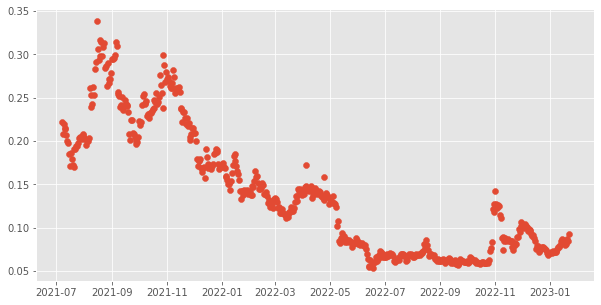

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(data=test, x = test.index, y = 'Close')

Text(0.5, 1.0, 'Close price by month. 2021-07-07 to 2023-01-22 (test data)')

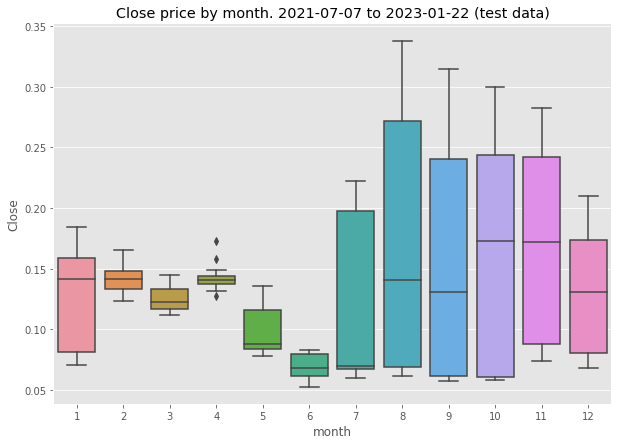

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(data=test,x='month',y='Close')
ax.set_title('Close price by month. 2021-07-07 to 2023-01-22 (test data)')

**Creating the model**

In [12]:
FEATURES = ['High','Low','Open','dayofweek','month','dayofyear']
TARGET = 'Close'

In [13]:
xtrain = train[FEATURES]
ytrain = train[TARGET]

xtest = test[FEATURES]
ytest = test[TARGET]

In [14]:
# params = { 'max_depth': [3,4,5,6],                                   # literally yebar masraf.
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7],
#            'early_stopping_rounds':[20,50,100],
#            'objective':['reg:linear']}
# xgbr1 = xgb.XGBRegressor(seed = 20)
# clf = GridSearchCV(estimator=xgbr1, 
#                    param_grid=params,
#                    scoring='neg_mean_squared_error', 
#                    verbose=1)
# clf.fit(xtrain, ytrain)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [15]:
par = {'colsample_bytree': 0.7, 'early_stopping_rounds': 20,
       'learning_rate': 0.01,'max_depth': 3,
       'n_estimators': 500, 'objective': 'reg:squarederror'}


xgbr = xgb.XGBRegressor(colsample_bytree=par['colsample_bytree'], # chatgpt wrote this little part for me <3
                        early_stopping_rounds=par['early_stopping_rounds'],
                        learning_rate=par['learning_rate'], 
                        max_depth=par['max_depth'], 
                        n_estimators=par['n_estimators'],
                        objective=par['objective'])

xgbr.fit(xtrain, ytrain,
        eval_set=[(xtrain, ytrain), (xtest, ytest)],
        verbose=100)

[0]	validation_0-rmse:0.485347	validation_1-rmse:0.364568
[100]	validation_0-rmse:0.177877	validation_1-rmse:0.133164
[200]	validation_0-rmse:0.065266	validation_1-rmse:0.051353
[300]	validation_0-rmse:0.024069	validation_1-rmse:0.023716
[400]	validation_0-rmse:0.009119	validation_1-rmse:0.014788
[499]	validation_0-rmse:0.003926	validation_1-rmse:0.012251


XGBRegressor(colsample_bytree=0.7, early_stopping_rounds=20, learning_rate=0.01,
             n_estimators=500, objective='reg:squarederror')

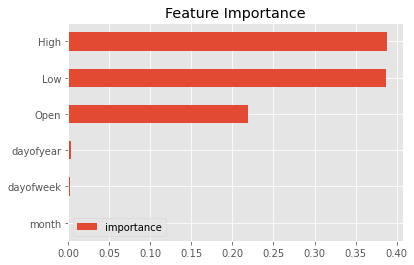

In [16]:
# making a feature importance dataframe and plot it to visualize the impact of each feature on the model.
fi = pd.DataFrame(data=xgbr.feature_importances_, 
             index=xgbr.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [17]:
# adding the prediction column to the test data, then merging it with the entire dataframe to visually compare results.
test['predictions'] = xgbr.predict(xtest)
extended_df = extended_df.merge(test[['predictions']], how='left', left_index=True, right_index=True)

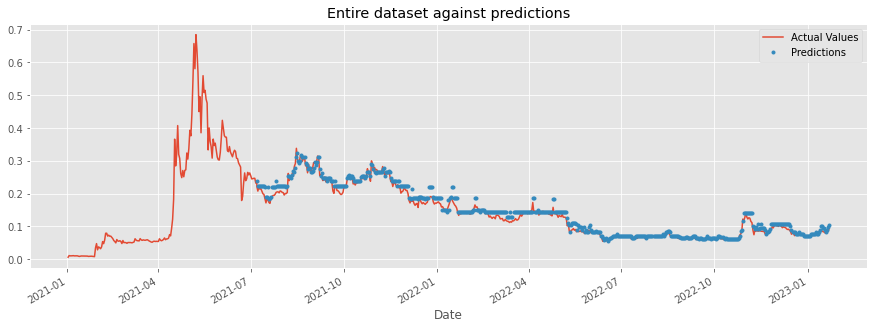

In [18]:
ax = extended_df['Close'].loc[extended_df.index > '01-01-2021'].plot(figsize=(15, 5))
extended_df['predictions'].plot(ax=ax, style='.')
plt.legend(['Actual Values', 'Predictions'])
ax.set_title('Entire dataset against predictions')
plt.show()

In [19]:
score = np.sqrt(mean_squared_error(test['Close'], test['predictions']))
print(f'RMSE Score on Test set: {score:0.3f}')
# 6 = RMSE Score on Test set: 0.01344
# 4 = RMSE Score on Test set: 0.01271
# 3 = RMSE Score on Test set: 0.01225

RMSE Score on Test set: 0.012


finding the best and the worst predictions

In [20]:
test['error']=np.abs(test[TARGET] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10) #worst

date
2022-01-16    0.044635
2022-04-26    0.044330
2022-04-06    0.043887
2021-07-18    0.040346
2021-12-07    0.037060
2022-01-15    0.036451
2021-07-26    0.034748
2021-07-15    0.034684
2021-12-24    0.033162
2022-01-20    0.031539
Name: error, dtype: float64

In [21]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10) #best

date
2022-12-31    0.000005
2022-11-23    0.000015
2021-12-23    0.000019
2022-07-28    0.000023
2022-01-29    0.000031
2022-07-19    0.000042
2021-08-29    0.000069
2021-08-25    0.000079
2022-08-20    0.000087
2022-10-04    0.000110
Name: error, dtype: float64